In [74]:
# Importing libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import randint, uniform

In [3]:
# importing kagglehub library
import kagglehub


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

# Reading the csv File
creditCardTransactions = pd.read_csv(os.path.join(path, "credit_card_transactions.csv"))

creditCardTransactions.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [4]:
# 1.2 Feature Description
creditCardTransactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
# 1.3 Dataset Structure
print(f"Number of rows: {creditCardTransactions.shape[0]}")
print(f"Number of columns: {creditCardTransactions.shape[1]}")

Number of rows: 1296675
Number of columns: 24


In [6]:
# 1.4 Missing Values and Duplicates
missing_values = creditCardTransactions.isnull().sum()
print(missing_values)

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64


In [7]:
unique_counts = creditCardTransactions.nunique()
unique_counts_df = pd.DataFrame(unique_counts).reset_index()
unique_counts_df.columns = ['Feature', 'Number of Unique Values']
unique_counts_df

,Feature,Number of Unique Values
0,Unnamed: 0,1296675
1,trans_date_trans_time,1274791
2,cc_num,983
3,merchant,693
4,category,14
5,amt,52928
6,first,352
7,last,481
8,gender,2
9,street,983


In [8]:
 # 1.4 Missing Values and Duplicates
duplicate_values = creditCardTransactions.duplicated().sum()
print(f"There is {duplicate_values} duplicate values in the dataset")

# Display the duplicates along with the original rows
creditCardTransactions[creditCardTransactions.duplicated(keep=False)]

There is 0 duplicate values in the dataset


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode


In [9]:
# 1.5 Statistical Summary
creditCardTransactions.describe()


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\711422904.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='is_fraud', data=creditCardTransactions, palette='viridis')


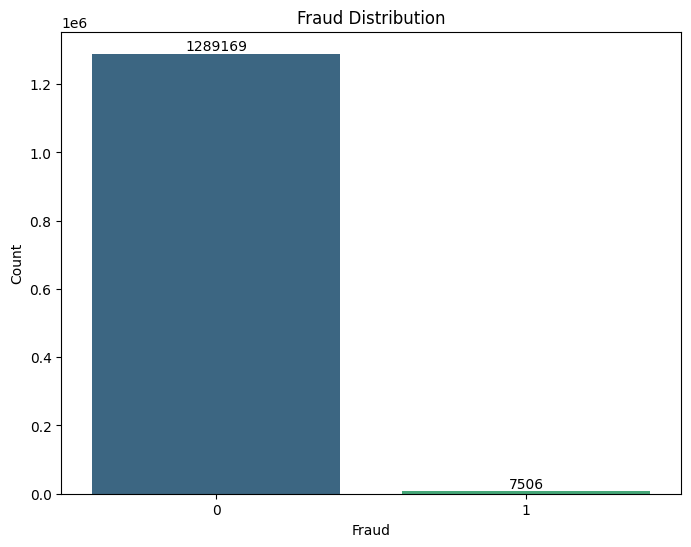

In [10]:
# 1.6 Data Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_fraud', data=creditCardTransactions, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black')
plt.title('Fraud Distribution')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

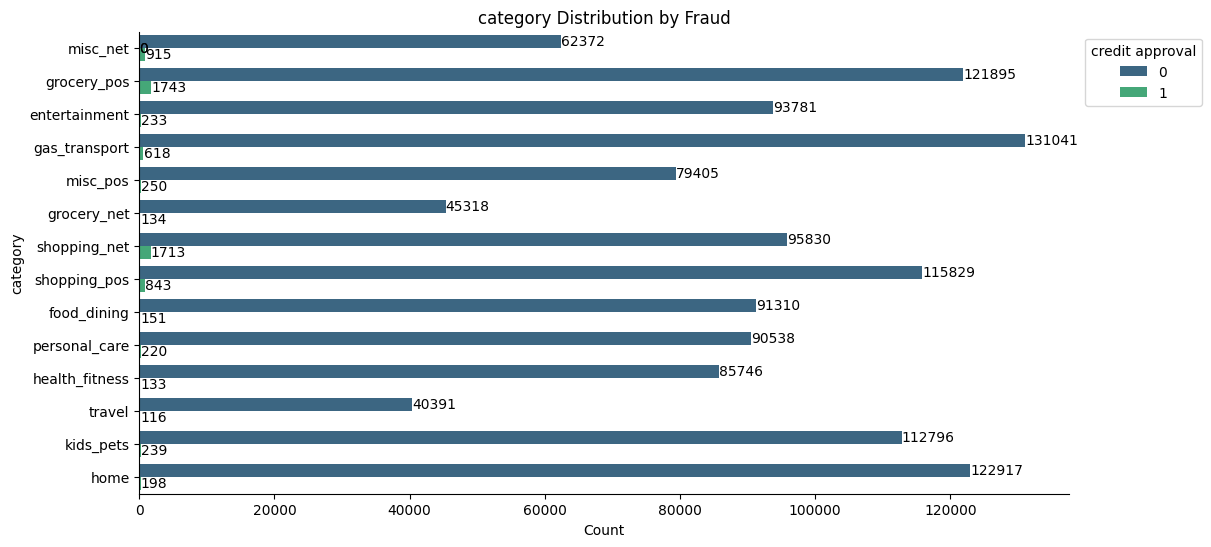

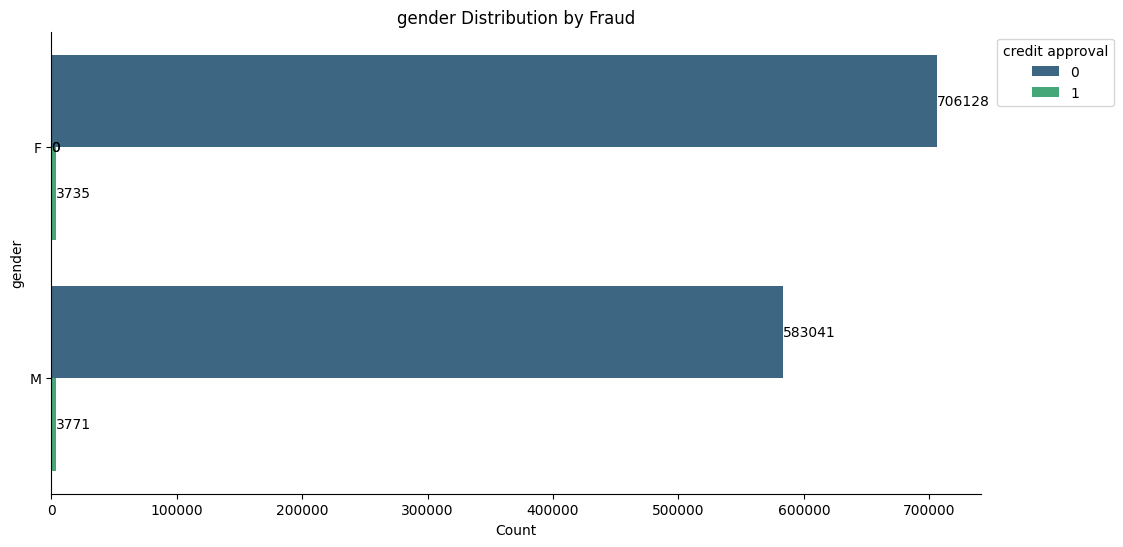

In [11]:
# 1.6 Data Distribution
categorical_columns = ['category', 'gender']

for column in categorical_columns:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(y=column, hue='is_fraud', data=creditCardTransactions, palette='viridis')
    plt.title(f'{column} Distribution by Fraud')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.legend(title='credit approval', loc='upper right', bbox_to_anchor=(1.15, 1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 10, p.get_y() + p.get_height() / 2,
                f'{int(width)}',
                ha='left', va='center')

    plt.show()


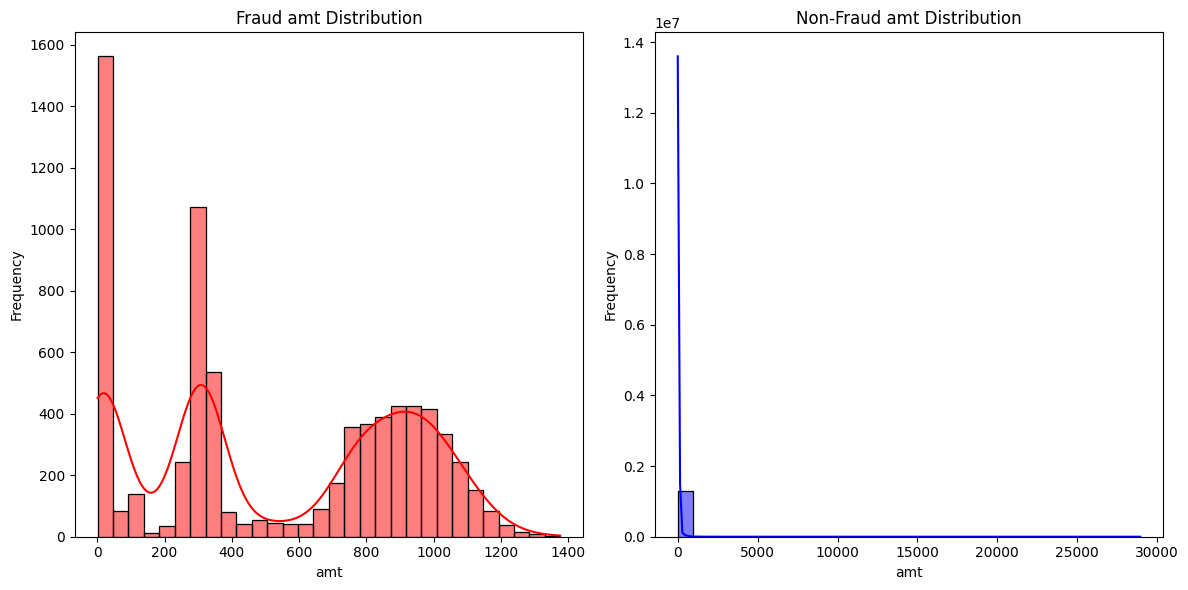

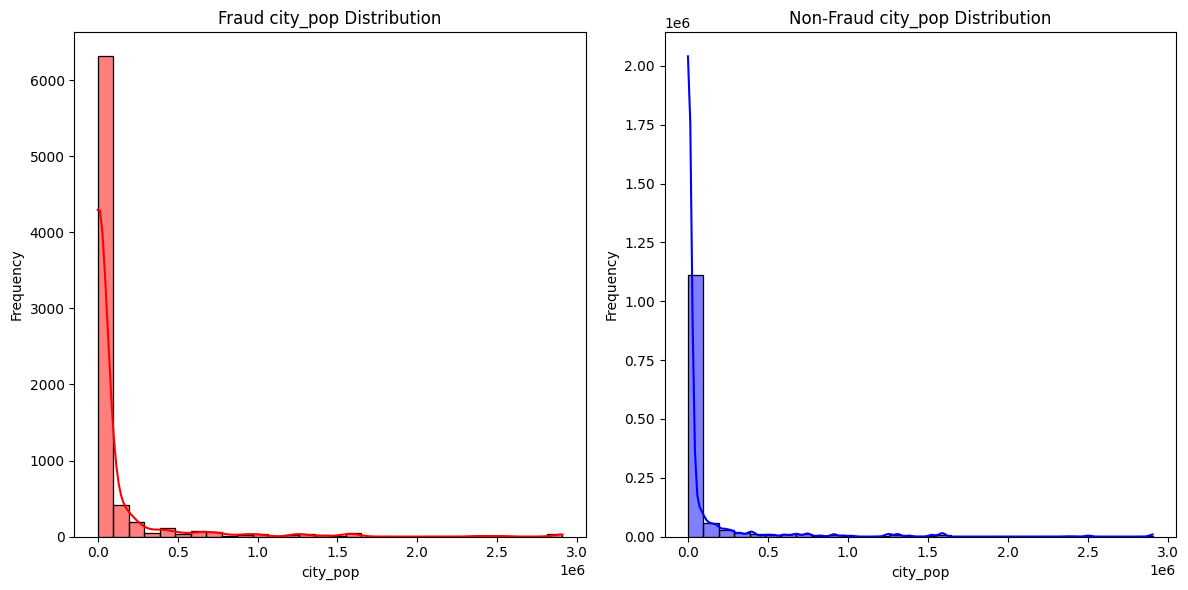

In [12]:
# 1.6 Data Distribution
numeric_columns = ['amt', 'city_pop']

for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(creditCardTransactions[creditCardTransactions['is_fraud'] == 1][column], bins=30, kde=True, color='red')
    plt.title(f'Fraud {column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(creditCardTransactions[creditCardTransactions['is_fraud'] == 0][column], bins=30, kde=True, color='blue')
    plt.title(f'Non-Fraud {column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\4058288572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['trans_date_trans_time'] = pd.to_datetime(fraud_transactions['trans_date_trans_time'])
C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\4058288572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['season'] = fraud_transactions['trans_date_trans_time'].dt.month % 12 // 3 + 1
C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\4058288572.py:9: SettingWithCopyWar

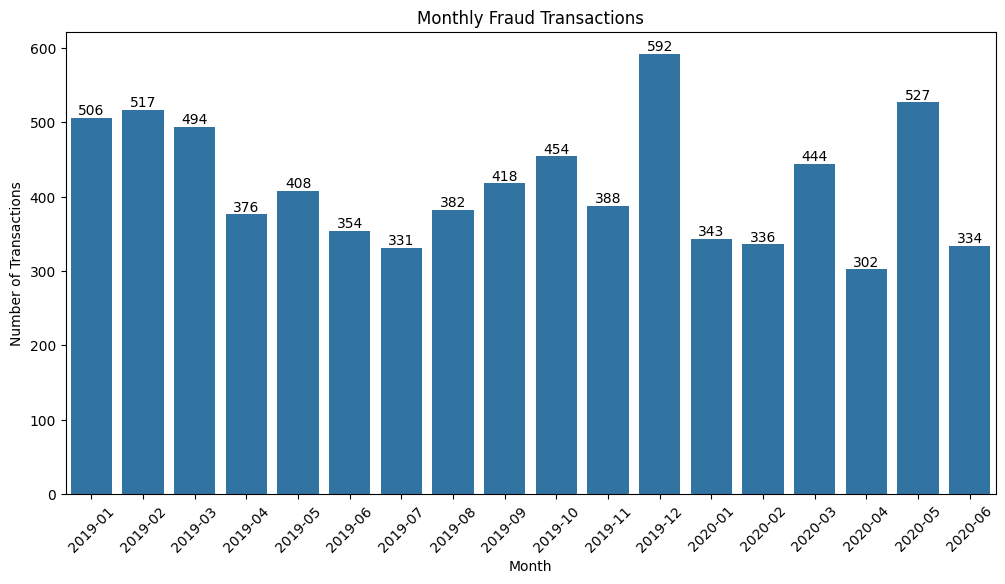

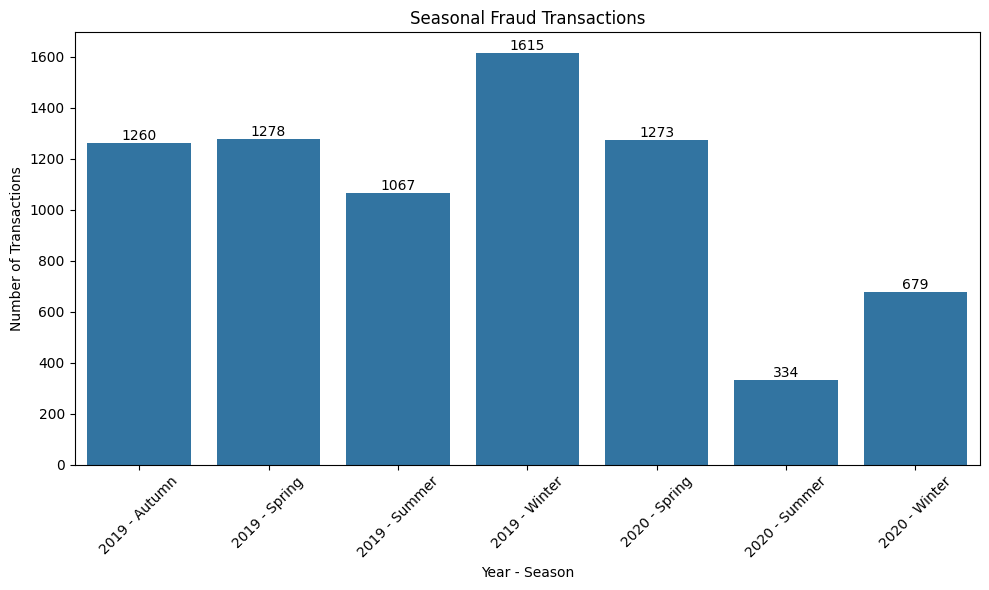

In [13]:
# 1.6 Data Distribution
data_copy = creditCardTransactions.copy()
fraud_transactions = data_copy[data_copy['is_fraud'] == 1]
non_fraud_transactions = data_copy[data_copy['is_fraud'] == 0]

fraud_transactions['trans_date_trans_time'] = pd.to_datetime(fraud_transactions['trans_date_trans_time'])
monthly_counts = fraud_transactions['trans_date_trans_time'].dt.to_period('M').value_counts().sort_index()
fraud_transactions['season'] = fraud_transactions['trans_date_trans_time'].dt.month % 12 // 3 + 1
fraud_transactions['year'] = fraud_transactions['trans_date_trans_time'].dt.year
fraud_transactions['year_season'] = fraud_transactions['year'].astype(str) + ' - ' + fraud_transactions['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'})
seasonal_counts = fraud_transactions['year_season'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_counts.index.astype(str), y=monthly_counts.values)
plt.title('Monthly Fraud Transactions')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

for i, count in enumerate(monthly_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=seasonal_counts.index, y=seasonal_counts.values)
plt.title('Seasonal Fraud Transactions')
plt.xlabel('Year - Season')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)

for i, count in enumerate(seasonal_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\2262674376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['hour'] = fraud_transactions['trans_date_trans_time'].dt.hour


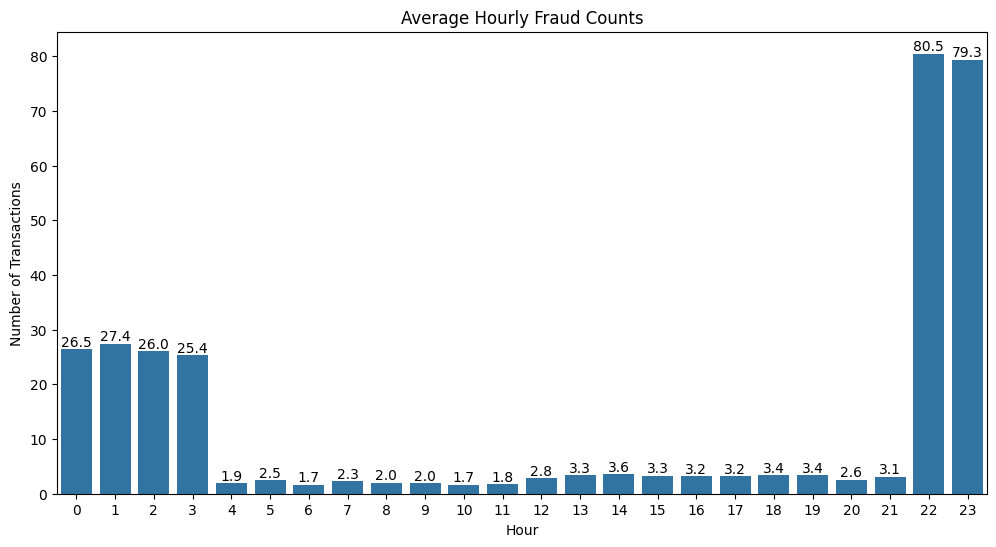

In [14]:
# 1.6 Data Distribution
fraud_transactions['hour'] = fraud_transactions['trans_date_trans_time'].dt.hour
hourly_fraud_counts = fraud_transactions['hour'].value_counts().sort_index()
average_hourly_fraud_counts = hourly_fraud_counts / fraud_transactions['hour'].value_counts().count()

plt.figure(figsize=(12, 6))
sns.barplot(x=average_hourly_fraud_counts.index, y=average_hourly_fraud_counts.values)
plt.title('Average Hourly Fraud Counts')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)

for i, count in enumerate(average_hourly_fraud_counts.values):
    plt.text(i, count, f"{count:.1f}", ha='center', va='bottom')

plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\2649074900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_transactions['weekday'] = fraud_transactions['trans_date_trans_time'].dt.weekday


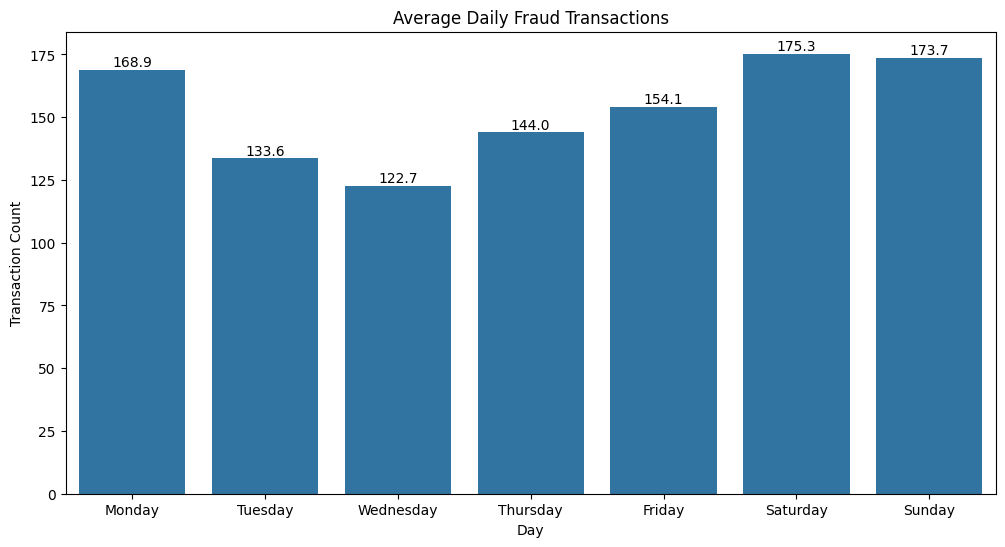

In [15]:
# 1.6 Data Distribution
fraud_transactions['weekday'] = fraud_transactions['trans_date_trans_time'].dt.weekday
weekday_fraud_counts = fraud_transactions['weekday'].value_counts().sort_index()
average_weekday_fraud_counts = weekday_fraud_counts / fraud_transactions['weekday'].value_counts().count()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.barplot(x=average_weekday_fraud_counts.index, y=average_weekday_fraud_counts.values)
plt.title('Average Daily Fraud Transactions')
plt.xlabel('Day')
plt.ylabel('Transaction Count')
plt.xticks(ticks=average_weekday_fraud_counts.index, labels=days_of_week, rotation=0)


for i, count in enumerate(average_weekday_fraud_counts.values):
    plt.text(i, count, f"{count:.1f}", ha='center', va='bottom')

plt.show()

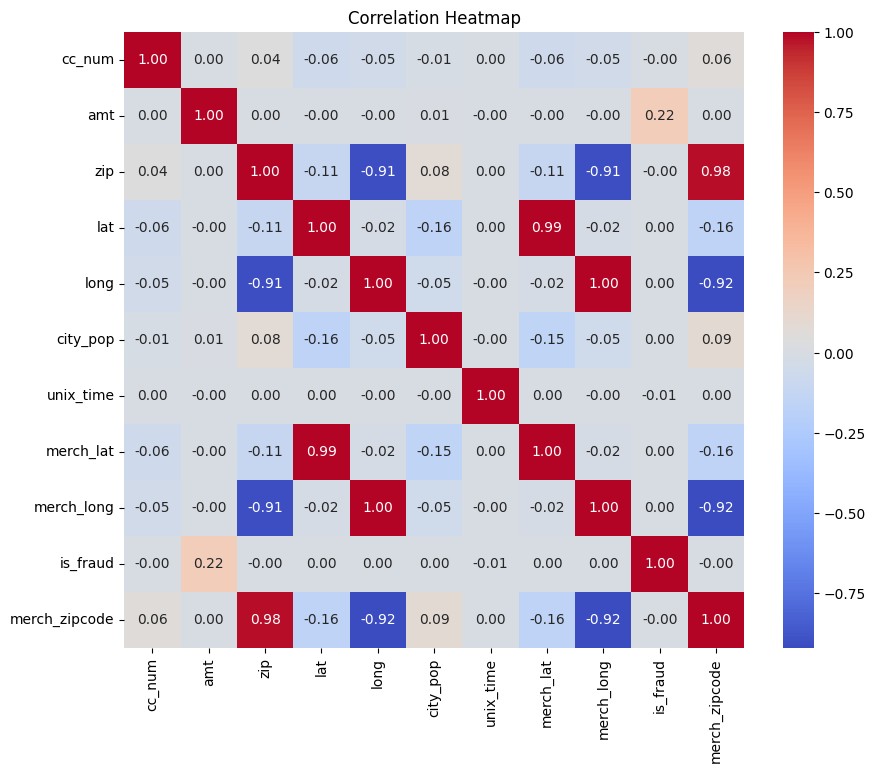


Correlation with Target Variable (is_fraud):
is_fraud         1.000000
amt              0.219404
city_pop         0.002136
lat              0.001894
merch_lat        0.001741
merch_long       0.001721
long             0.001721
cc_num          -0.000981
zip             -0.002162
merch_zipcode   -0.002992
unix_time       -0.005078
Name: is_fraud, dtype: float64


In [16]:
# 1.7 Correlation Analysis 
creditCardTransactions_numeric = creditCardTransactions.select_dtypes(include=["float64", "int64"])
creditCardTransactions_numeric = creditCardTransactions_numeric.drop(columns=['Unnamed: 0'])

correlation_matrix = creditCardTransactions_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


target_variable = 'is_fraud'
correlation_with_target = correlation_matrix[target_variable].sort_values(ascending=False)
print("\nCorrelation with Target Variable (is_fraud):")
print(correlation_with_target)

In [17]:
# 1.9 Handling Missing Data
# We have missing data in "merch_zipcode" only. It doesn't have any correlation with our target value "is_fraud". So, we will delete this column

creditCardTransactions = creditCardTransactions.drop(columns=['merch_zipcode'])

In [18]:
# 1.10 Encoding Categorical Variables

# Drop non-useful columns
creditCardTransactions = creditCardTransactions.drop(columns=["first", "last", "street"])

# Label encode binary categorical variables
creditCardTransactions["gender"] = creditCardTransactions["gender"].map({"F": 0, "M": 1})

creditCardTransactions.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,0,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,0,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,1,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,1,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,1,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [19]:
# 1.11 Feature Scaling

# Columns to scale
columns_to_scale = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

# Initialize the StandardScaler
scaler = StandardScaler()

# Create a copy of the DataFrame to preserve original data
creditCardTransactions_scaled = creditCardTransactions.copy()

# Scale only the specified columns
creditCardTransactions_scaled[columns_to_scale] = scaler.fit_transform(creditCardTransactions[columns_to_scale])

creditCardTransactions_scaled.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,-0.407826,0,Moravian Falls,NC,28654,-0.484420,0.657620,-0.282589,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,-1.858664,-0.494354,0.593864,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,0.230039,0,Orient,WA,99160,2.039120,-2.033870,-0.293670,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,-1.858662,2.078699,-2.030341,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,0.934149,1,Malad City,ID,83252,0.717754,-1.601537,-0.280406,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,-1.858662,0.902849,-1.592323,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,-0.158132,1,Boulder,MT,59632,1.515617,-1.590766,-0.287742,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,-1.858660,1.662886,-1.621848,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,-0.177094,1,Doe Hill,VA,24433,-0.023035,0.782279,-0.293835,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,-1.858651,0.026941,0.841909,0


In [20]:
# 1.12 Feature Selection

# Select only numerical columns
numerical_data = creditCardTransactions_scaled.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Correlation with the target variable
target_variable = 'is_fraud'
correlation_with_target = correlation_matrix[target_variable]

# Set a correlation threshold (0.1)
threshold = 0.1
selected_features = correlation_with_target[correlation_with_target.abs() > threshold].index

# Exclude the target variable itself from the selected features
selected_features = selected_features.drop(target_variable)

print("\nSelected Features Based on Correlation:")
print(selected_features)


Selected Features Based on Correlation:
Index(['amt'], dtype='object')


In [43]:
# 1.13 Algorithm Selection (Random Forest), 1.14 Data Splitting, 1.15 Model Training, 1.16 Model Evaluation

# Identify non-numeric columns
non_numeric_columns = creditCardTransactions.select_dtypes(exclude=['float64', 'int64']).columns

# Drop remaining non-numeric columns
creditCardTransactions = creditCardTransactions.drop(columns=non_numeric_columns)

# Shuffle the dataset
creditCardTransactions = shuffle(creditCardTransactions, random_state=42)

# Assuming 'amt' is the significant feature
significant_features = ['amt']  # Update with actual significant features list if needed
X = creditCardTransactions[significant_features]  # Selected feature(s)
y = creditCardTransactions['is_fraud']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9538

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    257814
           1       0.04      0.32      0.08      1521

    accuracy                           0.95    259335
   macro avg       0.52      0.64      0.53    259335
weighted avg       0.99      0.95      0.97    259335



In [49]:
# 1.13 Algorithm Selection (XGBoost), 1.14 Data Splitting, 1.15 Model Training, 1.16 Model Evaluation

X = creditCardTransactions.drop(columns=['is_fraud'])  # Include all columns except the target variable
y = creditCardTransactions['is_fraud']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9695

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    257814
           1       0.15      0.90      0.26      1521

    accuracy                           0.97    259335
   macro avg       0.57      0.94      0.62    259335
weighted avg       0.99      0.97      0.98    259335



In [45]:
# 1.18 Model Improvement (Random Forest)

# Preprocessing
# Identify non-numeric columns
non_numeric_columns = creditCardTransactions.select_dtypes(exclude=['float64', 'int64']).columns

# Drop non-numeric columns
creditCardTransactions = creditCardTransactions.drop(columns=non_numeric_columns)

# Feature and Target Selection
significant_features = ['amt']  # Update with actual significant features if needed
X = creditCardTransactions[significant_features]  # Selected feature(s)
y = creditCardTransactions['is_fraud']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Parameter Distributions
param_dist_rf = {
    'n_estimators': randint(50, 200),        # Number of trees
    'max_depth': randint(5, 20),            # Maximum depth of trees
    'min_samples_split': randint(2, 10),    # Minimum samples to split a node
    'min_samples_leaf': randint(1, 5),      # Minimum samples at a leaf node
    'class_weight': ['balanced', None],     # Handle class imbalance
}

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist_rf,
    n_iter=10,  # Test 20 random combinations
    scoring='f1',
    cv=2,
    random_state=42,
    n_jobs=-1,
    verbose=2   # Show progress updates
)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

# Get the Best Model
best_rf = random_search_rf.best_estimator_

# Evaluate the Best Model
y_pred_rf = best_rf.predict(X_test)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

print("\nBest Parameters (Random Forest):", random_search_rf.best_params_)

print("\nClassification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_rf))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Accuracy: 0.9944

Best Parameters (Random Forest): {'class_weight': None, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 87}

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257814
           1       0.54      0.26      0.35      1521

    accuracy                           0.99    259335
   macro avg       0.77      0.63      0.67    259335
weighted avg       0.99      0.99      0.99    259335



In [50]:
# Data Preprocessing
# Assuming your dataset is preprocessed, with numeric columns only
X = creditCardTransactions.drop(columns=['is_fraud'])  # All features except the target
y = creditCardTransactions['is_fraud']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define Hyperparameter Distributions for RandomizedSearchCV
param_dist_xgb = {
    'learning_rate': uniform(0.01, 0.3),      # Learning rate for boosting
    'max_depth': randint(3, 10),              # Maximum depth of trees
    'n_estimators': randint(50, 300),         # Number of boosting rounds
    'subsample': uniform(0.6, 0.4),           # Fraction of samples for training
    'colsample_bytree': uniform(0.6, 0.4),    # Fraction of features for each tree
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],  # Class imbalance
}

# Initialize XGBoost Classifier
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# RandomizedSearchCV for Hyperparameter Tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=50,               # Number of random combinations to try
    scoring='f1',            # Optimize for F1-score (important for imbalanced datasets)
    cv=3,                    # 3-fold cross-validation
    random_state=42,
    n_jobs=-1,               # Use all available CPU cores
    verbose=2                # Show progress updates
)

# Fit RandomizedSearchCV
random_search_xgb.fit(X_train, y_train)

# Get the Best Model
best_xgb = random_search_xgb.best_estimator_

# Evaluate the Best Model
y_pred_xgb = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy:.4f}")
print("\nBest Parameters (XGBoost):", random_search_xgb.best_params_)
print("\nClassification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_xgb))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\Omar\Desktop\ICS474-Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9978

Best Parameters (XGBoost): {'colsample_bytree': np.float64(0.7465447373174767), 'learning_rate': np.float64(0.14682099526511078), 'max_depth': 9, 'n_estimators': 239, 'scale_pos_weight': 1, 'subsample': np.float64(0.7529847965068651)}

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.93      0.67      0.78      1501

    accuracy                           1.00    259335
   macro avg       0.96      0.84      0.89    259335
weighted avg       1.00      1.00      1.00    259335



In [51]:
# 1.19 Validation (Random Forest)

# Data Preparation
X = creditCardTransactions[['amt', 'lat', 'long', 'city_pop', 'unix_time']]
y = creditCardTransactions['is_fraud']  # Target variable

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Stratified k-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Perform Cross-Validation and Compute F1-Score
cv_scores = cross_val_score(rf_clf, X, y, cv=skf, scoring='f1', n_jobs=-1)

# Display Cross-Validation Results
print(f"Cross-Validation F1-Score : {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation F1-Score : 0.6115 ± 0.0166


In [54]:
# 1.19 Validation (XGBoost)

# Data Preparation
X = creditCardTransactions.drop(columns=['is_fraud'])  # All features except the target
y = creditCardTransactions['is_fraud']  # Target variable

# Split the data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define Parameters
params = {
    'objective': 'binary:logistic',               # Binary classification
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    'eval_metric': 'logloss',                    # Evaluation metric
    'random_state': 42
}

# Train with Early Stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,          # Maximum number of boosting rounds
    early_stopping_rounds=10,     # Stop if no improvement for 10 rounds
    evals=evals,
    verbose_eval=True             # Show training progress
)

# Predict and Evaluate
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]  # Convert probabilities to binary

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	train-logloss:0.51035	eval-logloss:0.51033
[1]	train-logloss:0.40926	eval-logloss:0.40923
[2]	train-logloss:0.34663	eval-logloss:0.34668
[3]	train-logloss:0.30552	eval-logloss:0.30571
[4]	train-logloss:0.27705	eval-logloss:0.27732
[5]	train-logloss:0.25804	eval-logloss:0.25852
[6]	train-logloss:0.24472	eval-logloss:0.24537
[7]	train-logloss:0.23440	eval-logloss:0.23528
[8]	train-logloss:0.22775	eval-logloss:0.22894
[9]	train-logloss:0.22247	eval-logloss:0.22364
[10]	train-logloss:0.21865	eval-logloss:0.21991
[11]	train-logloss:0.21527	eval-logloss:0.21664
[12]	train-logloss:0.21280	eval-logloss:0.21424
[13]	train-logloss:0.20914	eval-logloss:0.21060
[14]	train-logloss:0.20733	eval-logloss:0.20894
[15]	train-logloss:0.20487	eval-logloss:0.20652
[16]	train-logloss:0.20314	eval-logloss:0.20490
[17]	train-logloss:0.19834	eval-logloss:0.20008
[18]	train-logloss:0.19622	eval-logloss:0.19799
[19]	train-logloss:0.19454	eval-logloss:0.19637
[20]	train-logloss:0.19217	eval-logloss:0.19412
[2

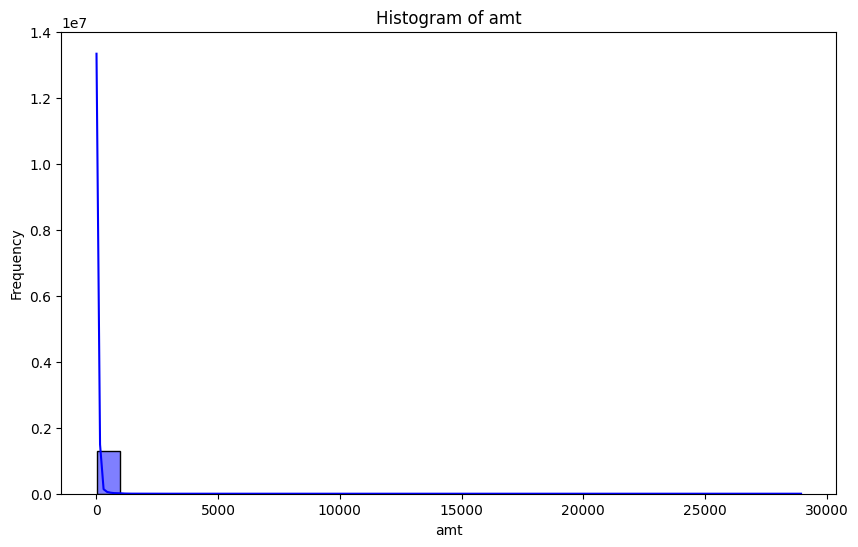

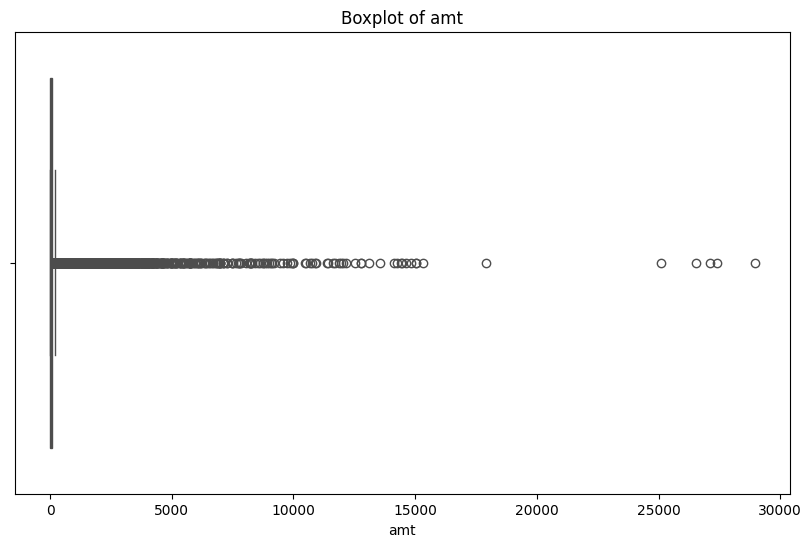

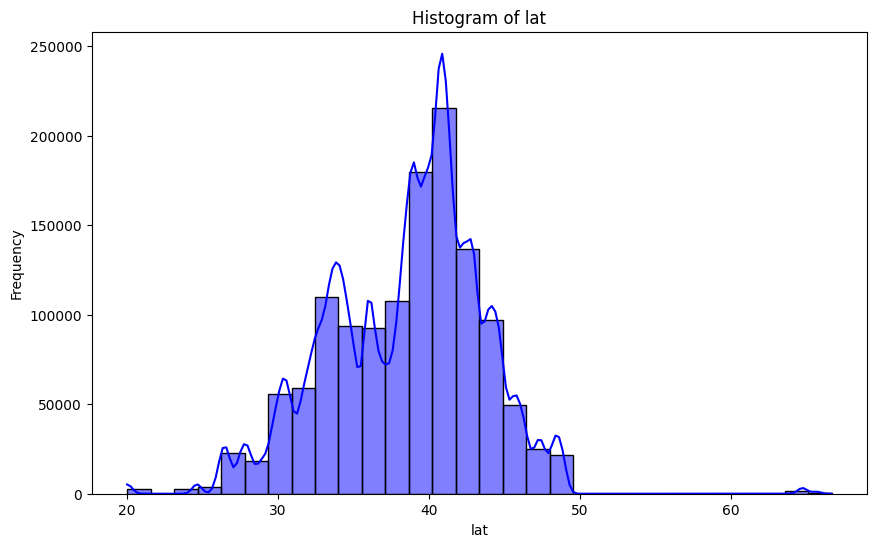

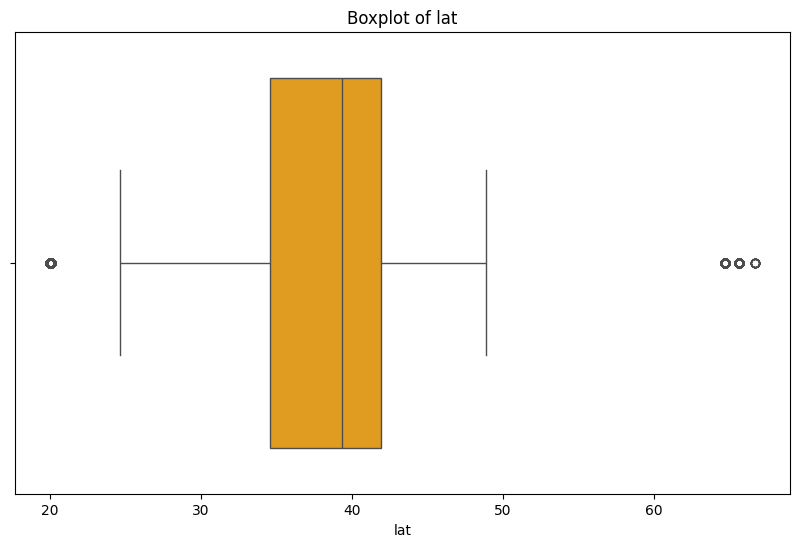

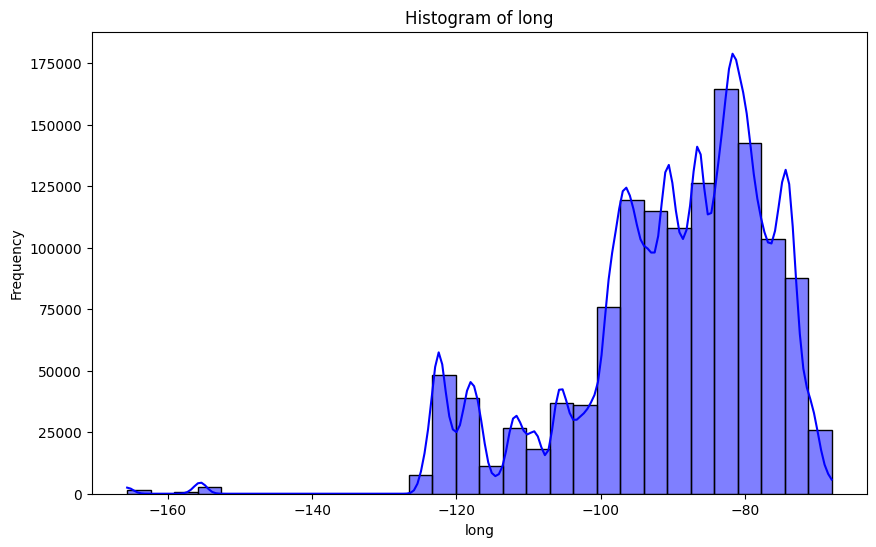

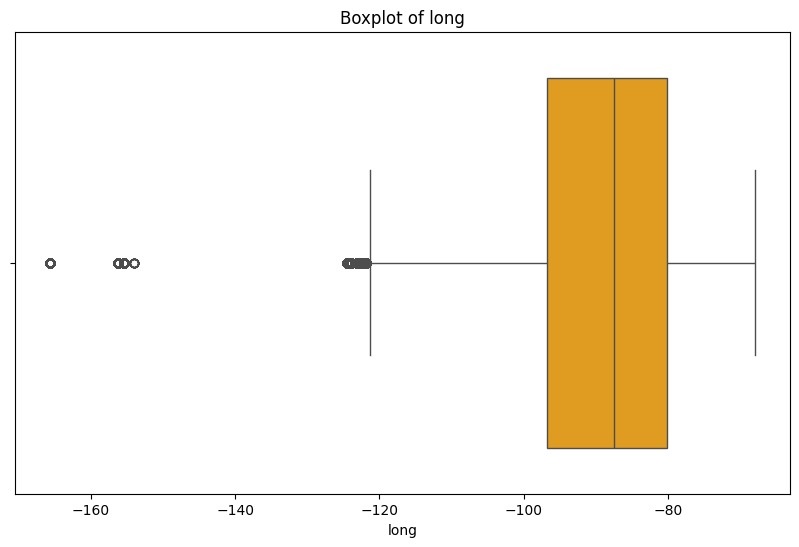

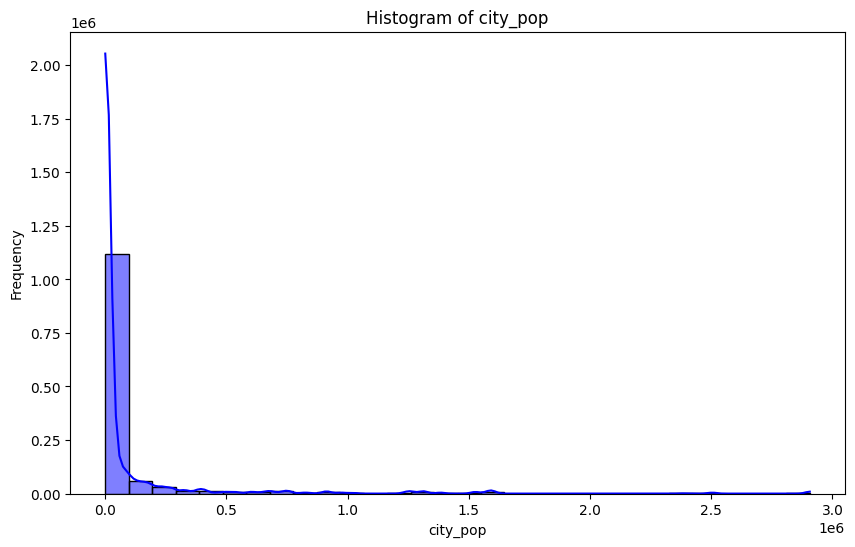

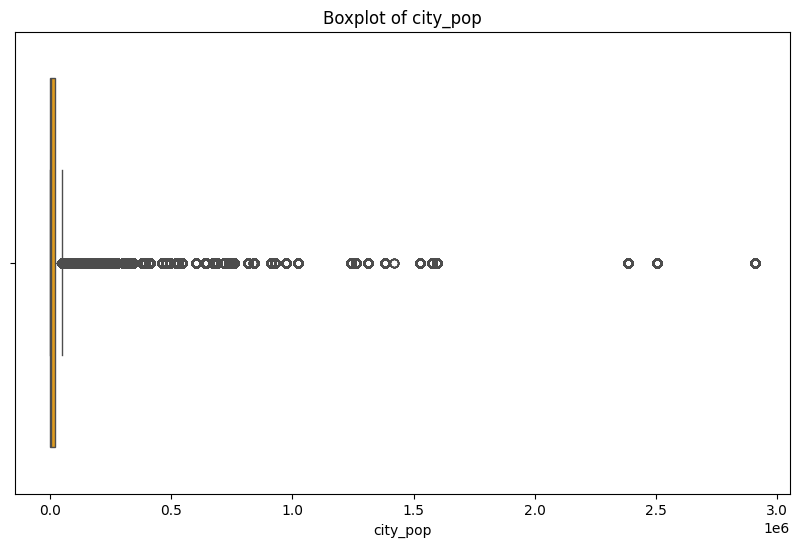

In [60]:
# 1.21 Data Distribution

# Specify Numerical
numerical_features = ['amt', 'lat', 'long', 'city_pop']
categorical_features = creditCardTransactions.select_dtypes(include=['object']).columns

# Visualize Numerical Features
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(creditCardTransactions[feature], kde=True, bins=30, color='blue')
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=creditCardTransactions[feature], color='orange')
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.show()

c:\Users\Omar\Desktop\ICS474-Project\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Omar\AppData\Local\Temp\ipykernel_11440\1366424013.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


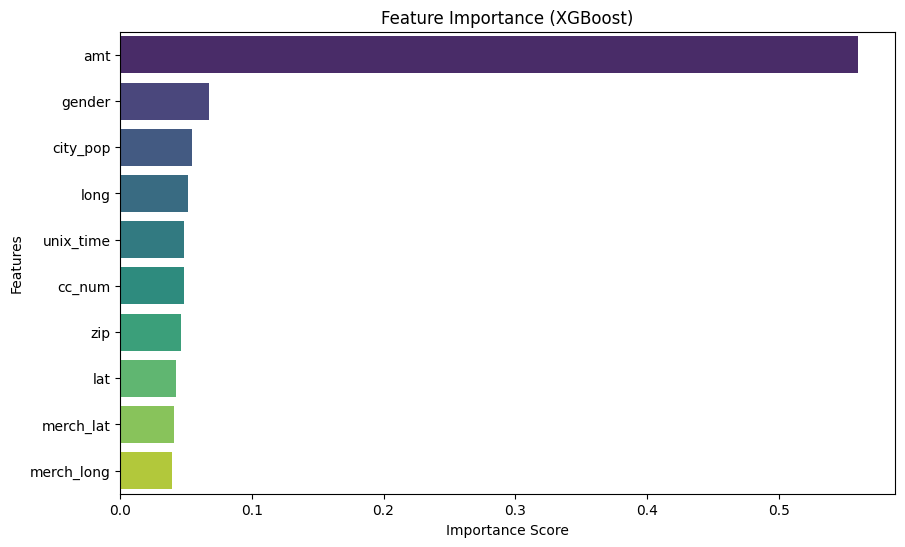

In [70]:
# 1.22 Feature Importance

# Train XGBoost Model

# Ensure 'Unnamed: 0' is excluded from X_train
X_train = X_train.drop(columns=['Unnamed: 0'], errors='ignore')  
xgb_clf.fit(X_train, y_train)  # Ensure model is trained on the correct features

# Extract Feature Importances
features = X_train.columns.tolist()  # Dynamically get feature names from the training data
feature_importances = xgb_clf.feature_importances_  # Extract feature importance scores from the trained model

# Step 3: Create DataFrame for Visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

100%|===================| 829847/829872 [19:16<00:00]        

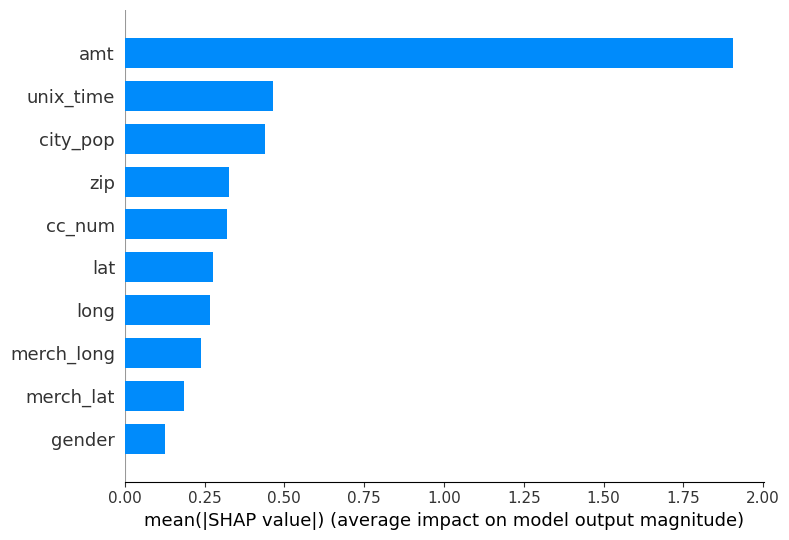

In [ ]:
# 1.23 Model Performance Across Features

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_clf, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train, plot_type="bar")